<a href="https://colab.research.google.com/github/Tannu0602/Financial-Fraud-Detection-Using-Transaction-Data/blob/main/Financial_Fraud_Detection_Using_Transaction_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing the Dependancies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


In [ ]:
df=pd.read_csv("/content/User0_credit_card_transactions.csv")
df.head(5)

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


In [ ]:
df.shape

(19963, 15)

In [ ]:
df['Is Fraud?'].value_counts()

,count
Is Fraud?,
No,19936
Yes,27


Since the data is imbalanced, we need to apply some resampling techniques.

Data Cleaning

In [ ]:
# We need to remove $ from amount to cast it as float
df['Amount'] = df['Amount'].str.replace('$','').astype(float)

In [ ]:
df.Amount.head(3)

,Amount
0,134.09
1,38.48
2,120.34


In [ ]:
df['Hour'] = df['Time'].str.split(':').str[0].astype(int)
df['Minute'] = df['Time'].str.split(':').str[1].astype(int)

In [ ]:
(df.Hour.head(3), df.Minute.head(3))

(0    6
 1    6
 2    6
 Name: Hour, dtype: int64,
 0    21
 1    42
 2    22
 Name: Minute, dtype: int64)

In [ ]:
# Removing unnecessary columnns like User
df = df.drop('User', axis=1)

Dealing with Null values

In [ ]:
df.isnull().sum()

,0
Card,0
Year,0
Month,0
Day,0
Time,0
Amount,0
Use Chip,0
Merchant Name,0
Merchant City,0
Merchant State,1317


In [ ]:
df.fillna(method='ffill', inplace = True)

<ipython-input-98-0042073afda4>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace = True)


In [ ]:
df.isnull().sum()

,0
Card,0
Year,0
Month,0
Day,0
Time,0
Amount,0
Use Chip,0
Merchant Name,0
Merchant City,0
Merchant State,0


In [ ]:
df['Errors?'].bfill(inplace=True)

<ipython-input-100-e2ac37b29c20>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Errors?'].bfill(inplace=True)


In [ ]:
df['Errors?'].isnull().sum()

0

Splitting of data into training and testing sets

In [ ]:
#Splitting the data into features and target variable
X=df.drop(['Is Fraud?', 'Time'],axis=1)
y=df['Is Fraud?']

#Splitting the data into training and testing sets
X_train, X_test, y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

Encoding Categorical features and Normalizing numerical features

In [ ]:
# Figuring out all the categorical and numerical variables among all the given features
print("No. of different values in 'Card':", df['Card'].nunique())
print("No. of different values in 'Merchant Name':", df['Merchant Name'].nunique())
print("No. of different values in 'Merchant City':", df['Merchant City'].nunique())
print("No. of different values in 'Merchant State':", df['Merchant State'].nunique())
print("No. of different values in 'Zip':", df['Zip'].nunique())
print("No. of different values in 'MCC':", df['MCC'].nunique())
print("No. of different values in 'Errors?':", df['Errors?'].nunique())
print("No. of different values in 'Use Chip':",df['Use Chip'].nunique())

No. of different values in 'Card': 5
No. of different values in 'Merchant Name': 552
No. of different values in 'Merchant City': 295
No. of different values in 'Merchant State': 40
No. of different values in 'Zip': 415
No. of different values in 'MCC': 94
No. of different values in 'Errors?': 8
No. of different values in 'Use Chip': 3


We conclude that other than (Card, Merchant name, Merchant City, Merchant State, Zip, MCC, Errors?, Use Chip), all are numerical features

In [ ]:
# Defining the categorical and numerical features
categorical_cols = ['Card', 'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC', 'Errors?', 'Use Chip']
numerical_cols = ['Year', 'Month', 'Day', 'Amount', 'Hour', 'Minute']

# Preprocessing pipelines for numerical and categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # Set sparse_output=False to avoid sparse matrix
numerical_transformer = StandardScaler()

# Combining the preprocessing steps into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Fit and transform the data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [ ]:
# Visualization helper function
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [ ]:
# Logistic Regression without Sampling
model_logistic = LogisticRegression()
model_logistic.fit(X_train_transformed, y_train)

LogisticRegression()

In [ ]:
# Predicting and evaluating Logistic Regression without Sampling
y_pred_logistic = model_logistic.predict(X_test_transformed)
print("Logistic Regression (Without Sampling):")
print(classification_report(y_test, y_pred_logistic))
print("Accuracy (Logistic Regression without Sampling):", accuracy_score(y_test, y_pred_logistic))

Logistic Regression (Without Sampling):
              precision    recall  f1-score   support

          No       1.00      1.00      1.00      3988
         Yes       0.00      0.00      0.00         5

    accuracy                           1.00      3993
   macro avg       0.50      0.50      0.50      3993
weighted avg       1.00      1.00      1.00      3993

Accuracy (Logistic Regression without Sampling): 0.998747808665164


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


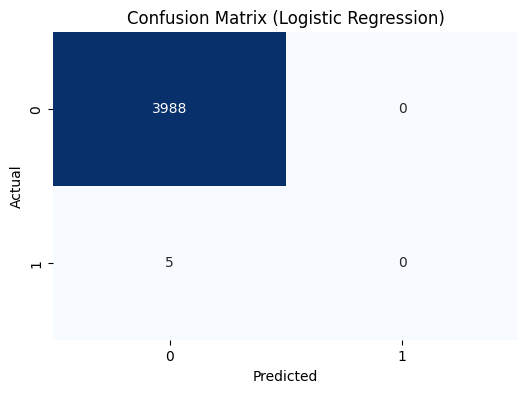

In [ ]:
# Confusion matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_logistic)
plot_confusion_matrix(cm_lr, title="Confusion Matrix (Logistic Regression)")

In [ ]:
# Random Forest without Sampling
model_random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
model_random_forest.fit(X_train_transformed, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Predicting and evaluating Random Forest without Sampling
y_pred_rf = model_random_forest.predict(X_test_transformed)
print("Random Forest (Without Sampling):")
print(classification_report(y_test, y_pred_rf))
print("Accuracy (Random Forest without Sampling):", accuracy_score(y_test, y_pred_rf))

Random Forest (Without Sampling):
              precision    recall  f1-score   support

          No       1.00      1.00      1.00      3988
         Yes       0.00      0.00      0.00         5

    accuracy                           1.00      3993
   macro avg       0.50      0.50      0.50      3993
weighted avg       1.00      1.00      1.00      3993

Accuracy (Random Forest without Sampling): 0.998747808665164


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


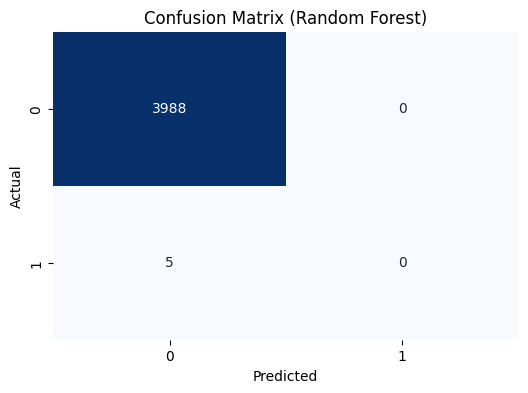

In [ ]:
# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cm_rf, title="Confusion Matrix (Random Forest)")

In [ ]:
# Handling class imbalance with random oversampling
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_transformed, y_train)

In [ ]:
# Logistic Regression with Oversampling
model_logistic.fit(X_train_resampled, y_train_resampled)

# Predicting and evaluating Logistic Regression with Oversampling
y_pred_logistic_resampled = model_logistic.predict(X_test_transformed)
print("Logistic Regression (Oversampling):")
print(classification_report(y_test, y_pred_logistic_resampled))
print("Accuracy (Logistic Regression with Oversampling):", accuracy_score(y_test, y_pred_logistic_resampled))

Logistic Regression (Oversampling):
              precision    recall  f1-score   support

          No       1.00      1.00      1.00      3988
         Yes       0.36      0.80      0.50         5

    accuracy                           1.00      3993
   macro avg       0.68      0.90      0.75      3993
weighted avg       1.00      1.00      1.00      3993

Accuracy (Logistic Regression with Oversampling): 0.9979964938642625


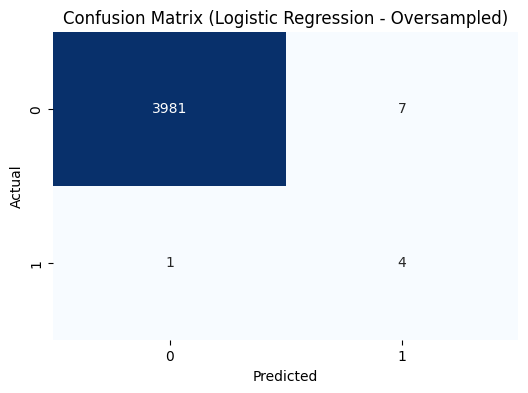

In [ ]:
# Confusion matrix for Logistic Regression (Oversampling)
cm_lr_over = confusion_matrix(y_test, y_pred_logistic_resampled)
plot_confusion_matrix(cm_lr_over, title="Confusion Matrix (Logistic Regression - Oversampled)")

In [ ]:
# Random Forest with Oversampling
model_random_forest.fit(X_train_resampled, y_train_resampled)

# Predicting and evaluating Random Forest with Oversampling
y_pred_rf_resampled = model_random_forest.predict(X_test_transformed)
print("Random Forest (Oversampling):")
print(classification_report(y_test, y_pred_rf_resampled))
print("Accuracy (Random Forest with Oversampling):", accuracy_score(y_test, y_pred_rf_resampled))

Random Forest (Oversampling):
              precision    recall  f1-score   support

          No       1.00      1.00      1.00      3988
         Yes       1.00      0.20      0.33         5

    accuracy                           1.00      3993
   macro avg       1.00      0.60      0.67      3993
weighted avg       1.00      1.00      1.00      3993

Accuracy (Random Forest with Oversampling): 0.9989982469321312


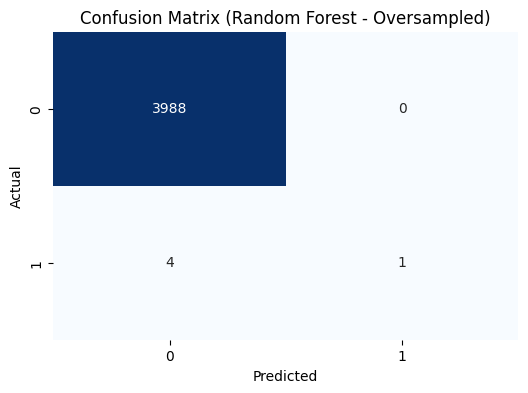

In [ ]:
# Confusion matrix for Random Forest with Oversampling
cm_rf = confusion_matrix(y_test, y_pred_rf_resampled)
plot_confusion_matrix(cm_rf, title="Confusion Matrix (Random Forest - Oversampled)")

In [ ]:
# Handling class imbalance with random undersampling
rus = RandomUnderSampler(random_state=42)
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train_transformed, y_train)

In [ ]:
# Logistic Regression with Undersampling
model_logistic.fit(X_train_undersampled, y_train_undersampled)
y_pred_logistic_undersample = model_logistic.predict(X_test_transformed)
print("Logistic Regression (Undersampling):")
print(classification_report(y_test, y_pred_logistic_undersample))
print("Accuracy:", accuracy_score(y_test, y_pred_logistic_undersample))

Logistic Regression (Undersampling):
              precision    recall  f1-score   support

          No       1.00      0.87      0.93      3988
         Yes       0.01      0.60      0.01         5

    accuracy                           0.87      3993
   macro avg       0.50      0.73      0.47      3993
weighted avg       1.00      0.87      0.93      3993

Accuracy: 0.8667668419734536


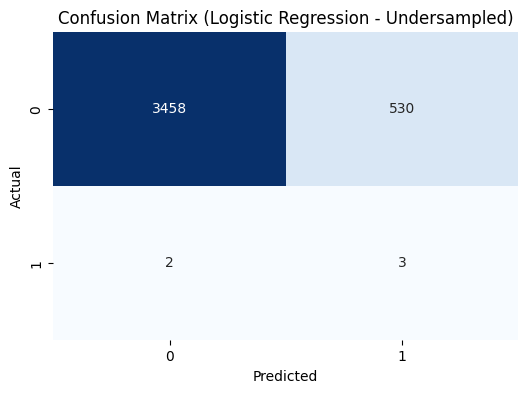

In [ ]:
# Confusion matrix for Logistic Regression (Undersampling)
cm_lr_over = confusion_matrix(y_test, y_pred_logistic_undersample)
plot_confusion_matrix(cm_lr_over, title="Confusion Matrix (Logistic Regression - Undersampled)")

In [ ]:
# Random Forest with Undersampling
model_random_forest.fit(X_train_undersampled, y_train_undersampled)
y_pred_rf_undersample = model_random_forest.predict(X_test_transformed)
print("Random Forest (Undersampling):")
print(classification_report(y_test, y_pred_rf_undersample))
print("Accuracy:", accuracy_score(y_test, y_pred_rf_undersample))

Random Forest (Undersampling):
              precision    recall  f1-score   support

          No       1.00      0.95      0.98      3988
         Yes       0.02      0.60      0.03         5

    accuracy                           0.95      3993
   macro avg       0.51      0.78      0.50      3993
weighted avg       1.00      0.95      0.97      3993

Accuracy: 0.9529176058101678


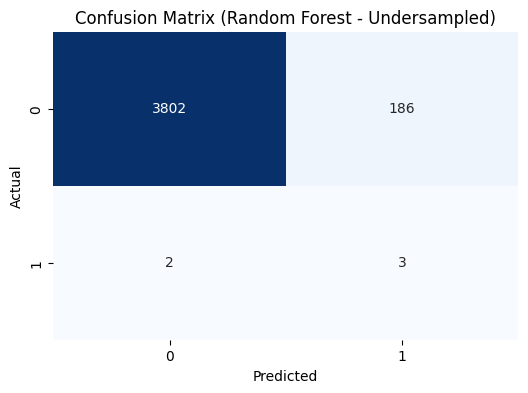

In [ ]:
# Confusion matrix for Random Forest with Undersampling
cm_rf = confusion_matrix(y_test, y_pred_rf_undersample)
plot_confusion_matrix(cm_rf, title="Confusion Matrix (Random Forest - Undersampled)")

In [ ]:
# Initialize and train the decision tree model
model_decision_tree = DecisionTreeClassifier(random_state=42)
model_decision_tree.fit(X_train_transformed, y_train)

# Make predictions with the decision tree model
y_pred_dt = model_decision_tree.predict(X_test_transformed)

# Evaluate the decision tree model
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))
print("Accuracy (Decision Tree without Sampling):", accuracy_score(y_test, y_pred_dt))

Decision Tree Classification Report:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00      3988
         Yes       0.67      0.40      0.50         5

    accuracy                           1.00      3993
   macro avg       0.83      0.70      0.75      3993
weighted avg       1.00      1.00      1.00      3993

Accuracy (Decision Tree without Sampling): 0.9989982469321312


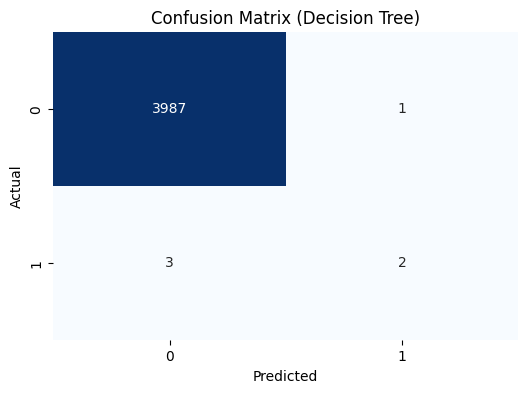

In [ ]:
# Confusion matrix for Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)
plot_confusion_matrix(cm_dt, title="Confusion Matrix (Decision Tree)")

In [ ]:
# Misclassified transactions analysis for the decision tree model
misclassified_index_dt = np.where(y_pred_dt != y_test)[0]

# Using y_test.index to get the correct original indices of the misclassified transactions
misclassified_transactions_dt = X_test.iloc[misclassified_index_dt]
misclassified_labels_dt = y_pred_dt[misclassified_index_dt]

for index in misclassified_index_dt:
    print("Transaction Details:")
    print(X_test.iloc[index])
    print("Predicted Label:", y_pred_dt[index])
    print("Actual Label:", y_test.iloc[index])
    print("="*50)

Transaction Details:
Card                                 3
Year                              2008
Month                               10
Day                                 12
Amount                           96.19
Use Chip             Swipe Transaction
Merchant Name      3189517333335617109
Merchant City                 La Verne
Merchant State                      CA
Zip                            91750.0
MCC                               5311
Errors?           Insufficient Balance
Hour                                15
Minute                              54
Name: 13684, dtype: object
Predicted Label: No
Actual Label: Yes
Transaction Details:
Card                                 3
Year                              2008
Month                               10
Day                                 20
Amount                           128.0
Use Chip            Online Transaction
Merchant Name      1108327803852946055
Merchant City                   ONLINE
Merchant State                     

In [ ]:
#Undersampling Technique
rus = RandomUnderSampler(random_state=42)
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train_transformed, y_train)

# Initialize and train the decision tree model on undersampled data
model_decision_tree_under = DecisionTreeClassifier(random_state=42)
model_decision_tree_under.fit(X_train_undersampled, y_train_undersampled)

# Make predictions with the decision tree model (undersampled)
y_pred_dt_under = model_decision_tree_under.predict(X_test_transformed)

# Evaluate the decision tree model (undersampled)
print("Decision Tree Classification Report (Undersampled):")
print(classification_report(y_test, y_pred_dt_under))
print("Accuracy (Decision Tree with Undersampling):", accuracy_score(y_test, y_pred_dt_under))

Decision Tree Classification Report (Undersampled):
              precision    recall  f1-score   support

          No       1.00      0.95      0.97      3988
         Yes       0.02      0.80      0.04         5

    accuracy                           0.95      3993
   macro avg       0.51      0.88      0.51      3993
weighted avg       1.00      0.95      0.97      3993

Accuracy (Decision Tree with Undersampling): 0.9499123466065614


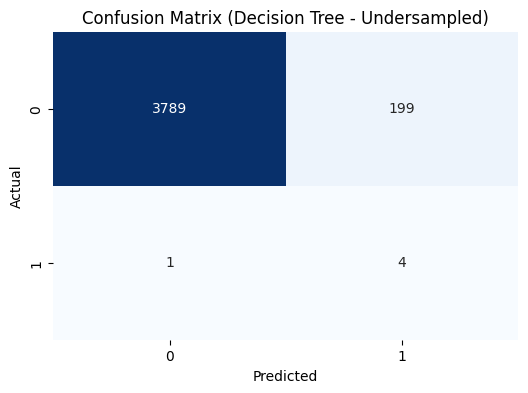

In [ ]:
# Confusion matrix for Decision Tree (Undersampled)
cm_dt = confusion_matrix(y_test, y_pred_dt_under)
plot_confusion_matrix(cm_dt, title="Confusion Matrix (Decision Tree - Undersampled)")

In [ ]:
#Oversampling Technique
ros = RandomOverSampler(random_state=42)
X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train_transformed, y_train)

# Initialize and train the decision tree model on oversampled data
model_decision_tree_over = DecisionTreeClassifier(random_state=42)
model_decision_tree_over.fit(X_train_oversampled, y_train_oversampled)

# Make predictions with the decision tree model (oversampled)
y_pred_dt_over = model_decision_tree_over.predict(X_test_transformed)

# Evaluate the decision tree model (oversampled)
print("Decision Tree Classification Report (Oversampled):")
print(classification_report(y_test, y_pred_dt_over))
print("Accuracy (Decision Tree with Oversampling):", accuracy_score(y_test, y_pred_dt_over))

Decision Tree Classification Report (Oversampled):
              precision    recall  f1-score   support

          No       1.00      1.00      1.00      3988
         Yes       0.50      0.60      0.55         5

    accuracy                           1.00      3993
   macro avg       0.75      0.80      0.77      3993
weighted avg       1.00      1.00      1.00      3993

Accuracy (Decision Tree with Oversampling): 0.998747808665164


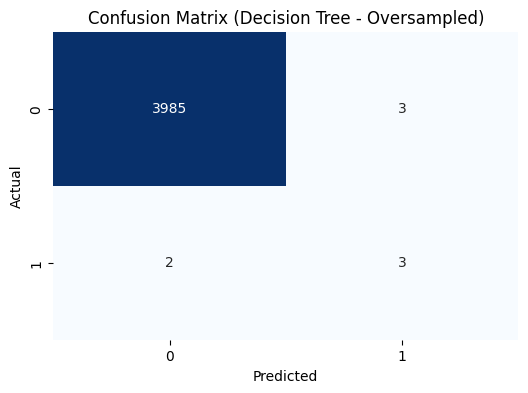

In [ ]:
# Confusion matrix for Decision Tree (Oversampled)
cm_dt = confusion_matrix(y_test, y_pred_dt_over)
plot_confusion_matrix(cm_dt, title="Confusion Matrix (Decision Tree - Oversampled)")

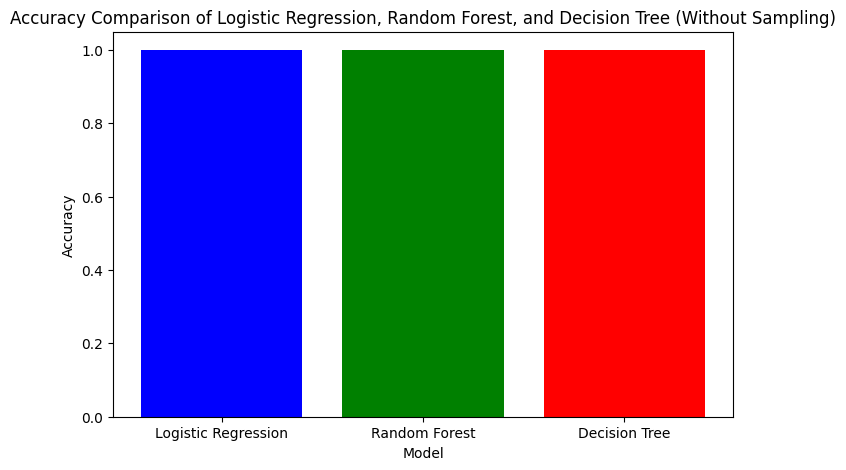

In [ ]:
### Accuracy Comparison of All Models (Without Sampling)
models = ['Logistic Regression', 'Random Forest', 'Decision Tree']
accuracies = [accuracy_score(y_test, y_pred_logistic), accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_dt)]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Logistic Regression, Random Forest, and Decision Tree (Without Sampling)')
plt.show()

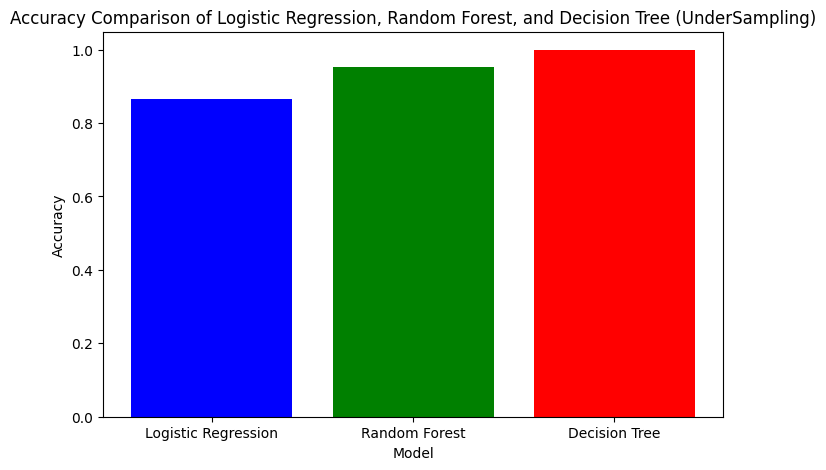

In [ ]:
### Accuracy Comparison of All Models (UnderSampling)
models = ['Logistic Regression', 'Random Forest', 'Decision Tree']
accuracies = [accuracy_score(y_test, y_pred_logistic_undersample), accuracy_score(y_test, y_pred_rf_undersample), accuracy_score(y_test, y_pred_dt_over)]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Logistic Regression, Random Forest, and Decision Tree (UnderSampling)')
plt.show()

Text(0.5, 1.0, 'Accuracy Comparison of Logistic Regression, Random Forest, and Decision Tree (OverSampling)')

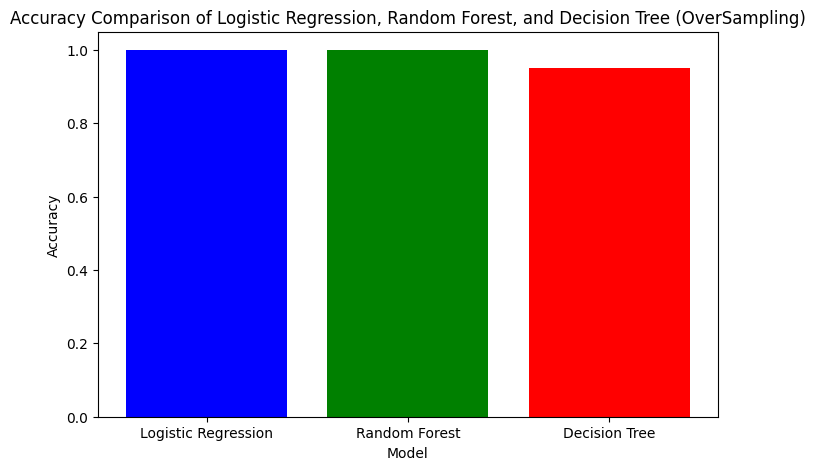

In [ ]:
### Accuracy Comparison of All Models (OverSampling)
models = ['Logistic Regression', 'Random Forest', 'Decision Tree']
accuracies = [accuracy_score(y_test, y_pred_logistic_resampled), accuracy_score(y_test, y_pred_rf_resampled), accuracy_score(y_test, y_pred_dt_under)]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Logistic Regression, Random Forest, and Decision Tree (OverSampling)')